# Data Preprocessing
* Creates a training and testing set (training set will be used for CV in shallow learners)
* preprocessed data from this notebook originally stored in datadrive/COVID_Anderson/preprocessed_09-20-2021

In [1]:
!python3 -m pip install scikit-learn

import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedGroupKFold

### Seed ###
random_state = 1234
np.random.seed(random_state)

Defaulting to user installation because normal site-packages is not writeable


## User Variables

In [2]:
from datathon_icd_columns import ICD_COLUMN_NAMES

ORIGINAL_DATA_PATH = "/Users/lhuang21/Documents/Programming/MD+_Datathon_2023/ckd_icd_codes_ckd_status_stages_grouped_hadmid_v2.csv"

## Folder paths ##
data_folder = '../Data/'

## Drop Observations missing more than 40% of feautures ##
observation_cutoff = 0.4
## Drop features that are missing for >75% of observations ##
missing_data_cutoff = 0.75
## Percentage of observations that have a non-zero value for a one-hot encoded feature ##
# drop one-hot features that have less than 1% non-zero frequency
onehot_outlier_cutoff = 0.01

## Train, Testing split ##
split_percentages = [0.8, 0.2]
## Number of Splits based on test set percent ##
n_splits = int(1/split_percentages[-1])

## Outcome to balance splits ##
outcome_of_interest = 'ckd_status'

## Outcome variable names ##
outcome_cols = np.array([outcome_of_interest, 'ckd_stage'])

## List of continuous features before preprocessing ##
continuous_features = np.array(
    ['F_age', 'F_max_bmi', 'F_max_blood_pressure_systolic', 'F_max_blood_pressure_diastolic'])

## List of discrete features before preprocessing ##
discrete_features = np.array(ICD_COLUMN_NAMES)
n_totalfeatures = len(continuous_features) + len(discrete_features)
print('Total Features Before Preprocessing: %s' % n_totalfeatures)
print('Total Columns Before Preprocessing (with new outcome of interest): %s' %
      (n_totalfeatures+len(outcome_cols)))


Total Features Before Preprocessing: 131
Total Columns Before Preprocessing (with new outcome of interest): 133


## Basic Processing/Cleanup
* Drop the one patient with NaN non-continuous data
* Drop features missing values in >75% of patients
* Drop one-hot featuers with less than 1% incidence (non-zero frequency)
* Split train/test 80/20

### Load Data 

In [3]:
## Read Data from CSV ##
df_overall = pd.read_csv(ORIGINAL_DATA_PATH, index_col=0); #df_overall.index.name = 'subject_id_hadm_id';
data_headers= np.array(df_overall.columns)
original_features = data_headers[ [header not in outcome_cols for header in data_headers] ]

# strip whitespace from column names
df_overall.columns = df_overall.columns.str.strip()

print('df_overall shape: %s'% (df_overall.shape,))

list(df_overall.columns)

df_overall shape: (365693, 157)


/var/folders/65/qxp2fcwj00bff0rdg3hmhyx80000gn/T/ipykernel_57166/2128287132.py:2: DtypeWarning: Columns (30,41,42,68,69,70,71,85,89,105,106,107,125,126,127) have mixed types. Specify dtype option on import or set low_memory=False.
  df_overall = pd.read_csv(ORIGINAL_DATA_PATH, index_col=0); #df_overall.index.name = 'subject_id_hadm_id';


['subject_id_hadm_id',
 'subject_id',
 'hadm_id',
 'F_age',
 'F_gender',
 'F_max_bmi',
 'ckd_status',
 'race',
 'insurance',
 'language',
 'ckd_stage',
 'F_icd_code_0389',
 'F_icd_code_2449',
 'F_icd_code_25000',
 'F_icd_code_25040',
 'F_icd_code_25060',
 'F_icd_code_2720',
 'F_icd_code_2724',
 'F_icd_code_2749',
 'F_icd_code_2760',
 'F_icd_code_2761',
 'F_icd_code_2762',
 'F_icd_code_27651',
 'F_icd_code_27652',
 'F_icd_code_2767',
 'F_icd_code_2768',
 'F_icd_code_27800',
 'F_icd_code_2809',
 'F_icd_code_2851',
 '28521',
 'F_icd_code_2859',
 'F_icd_code_2875',
 'F_icd_code_28860',
 'F_icd_code_30000',
 'F_icd_code_3051',
 'F_icd_code_311',
 'F_icd_code_32723',
 'F_icd_code_33829',
 'F_icd_code_3572',
 'F_icd_code_4019',
 '40390',
 '40391',
 'F_icd_code_41071',
 'F_icd_code_412',
 'F_icd_code_41400',
 'F_icd_code_41401',
 'F_icd_code_4168',
 'F_icd_code_4240',
 'F_icd_code_4241',
 'F_icd_code_42731',
 'F_icd_code_42789',
 'F_icd_code_4280',
 'F_icd_code_42822',
 'F_icd_code_42823',
 'F

### Outcome of Interest 

### Drop Observations with NaNs in over 40% of its features (only one)

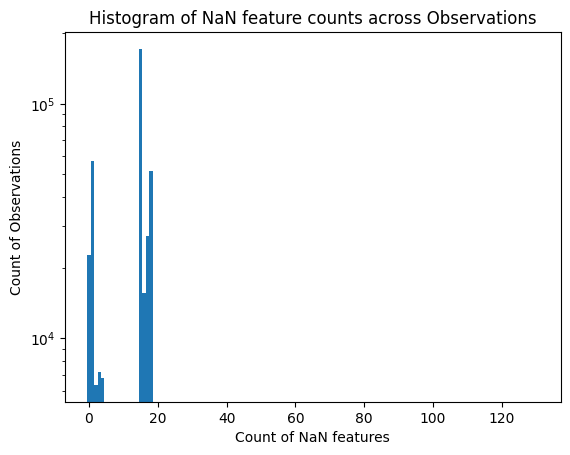

In [5]:
plt.hist( df_overall.isnull().sum(axis=1), bins=np.linspace(0,n_totalfeatures,n_totalfeatures+1), align='left', log=True );
plt.xlabel('Count of NaN features')
plt.ylabel('Count of Observations')
plt.title('Histogram of NaN feature counts across Observations')
plt.show()

In [6]:
## Drop Patients with NaNs in non-continuous variables ##
print( 'Dataframe Shape (Before): %s'% (df_overall.shape,) )
df_overall = df_overall[ df_overall.isnull().sum(axis=1)/n_totalfeatures <= observation_cutoff ]
print( 'Dataframe Shape (After): %s'% (df_overall.shape,) )

Dataframe Shape (Before): (365693, 157)
Dataframe Shape (After): (365693, 157)


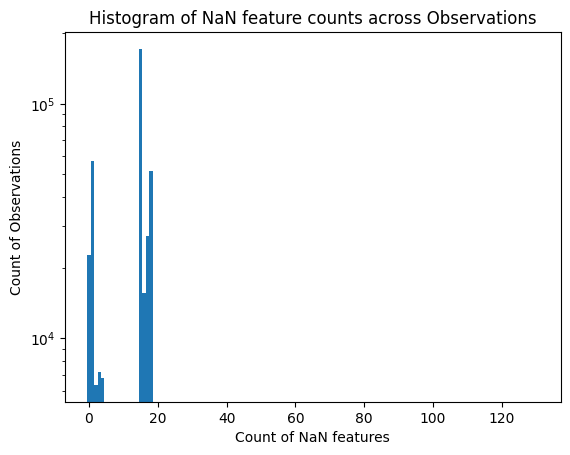

In [7]:
plt.hist( df_overall.isnull().sum(axis=1), bins=np.linspace(0,n_totalfeatures,n_totalfeatures+1), align='left', log=True );
plt.xlabel('Count of NaN features')
plt.ylabel('Count of Observations')
plt.title('Histogram of NaN feature counts across Observations')
plt.show()

### Drop Missing Features (missing in >75% of patients)

In [8]:
## Features with missing data exceeding cutoff ##
null_percent = np.sum(df_overall.isnull())/len(df_overall)
too_much_missing_data_cols = (null_percent[ null_percent > missing_data_cutoff]).index

print('Dropped Features (missing data): %s'% (too_much_missing_data_cols,) )
print( 'Dataframe Shape (Before): %s'% (df_overall.shape,) )
df_overall = df_overall.drop(too_much_missing_data_cols, axis=1)
print( 'Dataframe Shape (After): %s'% (df_overall.shape,) )

## Update continuous and discrete feature lists ##
continuous_features = np.array( [ item for item in continuous_features if item not in too_much_missing_data_cols ] )
discrete_features = np.array( [ item for item in discrete_features if item not in too_much_missing_data_cols ] )

## Total Features ##
n_totalfeatures = len(continuous_features) + len(discrete_features)
print('Total Features: %s'% n_totalfeatures)

Dropped Features (missing data): Index([], dtype='object')
Dataframe Shape (Before): (365693, 157)
Dataframe Shape (After): (365693, 157)
Total Features: 131


/Users/lhuang21/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


### Drop Sparse Discrete Features (incidence less than 1%)

In [9]:
# Number of observations with non-zero value / number of patients with non-null value
one_hot_outlier_cols = (df_overall[discrete_features] != 0).sum() / df_overall[discrete_features].notnull().sum() 
one_hot_outlier_cols = one_hot_outlier_cols [ (df_overall[discrete_features] != 0).sum() 
                                             / df_overall[discrete_features].notnull().sum() < onehot_outlier_cutoff ].index

print('Dropped Features (outliers): %s'% (one_hot_outlier_cols,) )
print( 'Dataframe Shape (Before): %s'% (df_overall.shape,) )
df_overall = df_overall.drop(one_hot_outlier_cols, axis=1)
print( 'Dataframe Shape (After): %s'% (df_overall.shape,) )

## Update continuous and discrete feature lists ##
continuous_features = np.array( [ item for item in continuous_features if item not in one_hot_outlier_cols ] )
discrete_features = np.array( [ item for item in discrete_features if item not in one_hot_outlier_cols ] )

## Total Features ##
n_totalfeatures = len(continuous_features) + len(discrete_features)
print('Total Features: %s'% n_totalfeatures)

Dropped Features (outliers): Index(['F_icd_code_58381', 'F_icd_code_5845', 'F_icd_code_I214',
       'F_icd_code_I5023'],
      dtype='object')
Dataframe Shape (Before): (365693, 157)
Dataframe Shape (After): (365693, 153)
Total Features: 127


## Create training and testing set

In [10]:
## Stratified K Fold balanced on outcome_of_interest ##
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

data_splits = skf.split(X=df_overall, y=df_overall[outcome_of_interest], groups=df_overall.index)

## Training and Testing rows ##
train_idx, test_idx= data_splits.__next__()
## Set rows ##
df_train = df_overall.iloc[train_idx]
df_test = df_overall.iloc[test_idx]

## Remove index ##
df_overall =df_overall.reset_index()
df_train =df_train.reset_index()
df_test =df_test.reset_index()

print('Training: %s'% len(df_train) )
print('Testing: %s'% len(df_test) )
print('Total: %s'% len(df_overall) )

Training: 292554
Testing: 73139
Total: 365693


In [11]:
# LH commenting out because we're using public data, don't need to drop patient_id

## Drop Patient ID column ##
# df_test = df_test.drop('patient_id', axis='columns')
# df_train = df_train.drop('patient_id', axis='columns')

## Normalize Continuous Variables
- Training
- Testing (+Training)

### Training Dataset
* Fit and transform using only train set

In [12]:
sscaler = StandardScaler()

## Fit Training and Transform Training -> normalized_continuous_df ##
normalized_continuous_df = sscaler.fit_transform(df_train[continuous_features])
## Dataframe with columns ##
normalized_continuous_df = pd.DataFrame( normalized_continuous_df, columns=continuous_features)

## Update Training dataset with Normalized values ##
train_normalized_df = df_train.copy()
for i in continuous_features:
    train_normalized_df[i] = normalized_continuous_df[i]

### Testing Dataset
* Fit on train+test set, transform on test set only

In [13]:
sscaler = StandardScaler()

## Fit on Training and Testing: continuous features ##
sscaler.fit(df_overall[continuous_features])

## Transform Testing -> normalized_continuous_df ##
normalized_continuous_df = sscaler.transform( df_test[continuous_features] )
## Dataframe with columns ##
normalized_continuous_df = pd.DataFrame( normalized_continuous_df, columns=continuous_features)
## Total Features ##
n_totalfeatures = len(continuous_features) + len(discrete_features)
print('Total Features: %s'% n_totalfeatures)
## Update Testing dataset with Normalized values ##
test_normalized_df = df_test.copy()
for i in continuous_features:
    test_normalized_df[i] = normalized_continuous_df[i]

Total Features: 127


## Data Imputation on all variables (KNN Imputer)
- Training
- Testing (+Training)

In [14]:
## Updated list of features ##
feature_list = np.concatenate([continuous_features,discrete_features])

##### Train Set
1) Fit the KNN Imputer on only the Train dataset. <br>
2) Use the fitted KNN imputer to replace NaNs in Train dataset. <br>

In [15]:
imputer = KNNImputer(n_neighbors=3)

## Fit Training and Transform Training: features (not outcomes) ##
imputated_df = imputer.fit_transform(train_normalized_df[feature_list])
## Dataframe -> imputated_df ##
imputated_df = pd.DataFrame(imputated_df, columns=feature_list)

## Update Training dataset with Imputed values ##
train_imputated_df = train_normalized_df.copy()
for i in feature_list:
    train_imputated_df[i] = imputated_df[i]


##### Test Set
1) Fit the KNN Imputer on the train+test set. <br>
2) Use the fitted KNN imputer to transform/fill in the missing values of the test set. <br>

In [16]:
imputer = KNNImputer(n_neighbors=3)

## Fit on Training and Testing: features (not outcomes) ##
imputer.fit(pd.concat((train_normalized_df, test_normalized_df))[feature_list])

## Transform Testing -> imputated_df ##
imputated_df = imputer.transform(test_normalized_df[feature_list])
## Dataframe ##
imputated_df = pd.DataFrame(imputated_df, columns=feature_list)

## Update Testing dataset with Imputed columns ##
test_imputated_df = test_normalized_df.copy()
for i in feature_list:
    test_imputated_df[i] = imputated_df[i]


### Save to CSV

In [17]:
## Print Data Descriptors (patient_id is not in feature list or outcome_cols) ##
print( 'Total Features: %s'% len(feature_list) )
print( 'Total Outcomes: %s'% len(outcome_cols) )
print( 'Train Shape: %s'% (train_imputated_df.shape,) )
print( 'Test Shape: %s'% (test_imputated_df.shape,) )
train_imputated_df.to_csv(data_folder+'train_data.csv', index=False)
test_imputated_df.to_csv(data_folder+'test_data.csv', index=False)

Total Features: 127
Total Outcomes: 2
Train Shape: (292554, 154)
Test Shape: (73139, 154)


### Plot: Compare Continuous Distributions

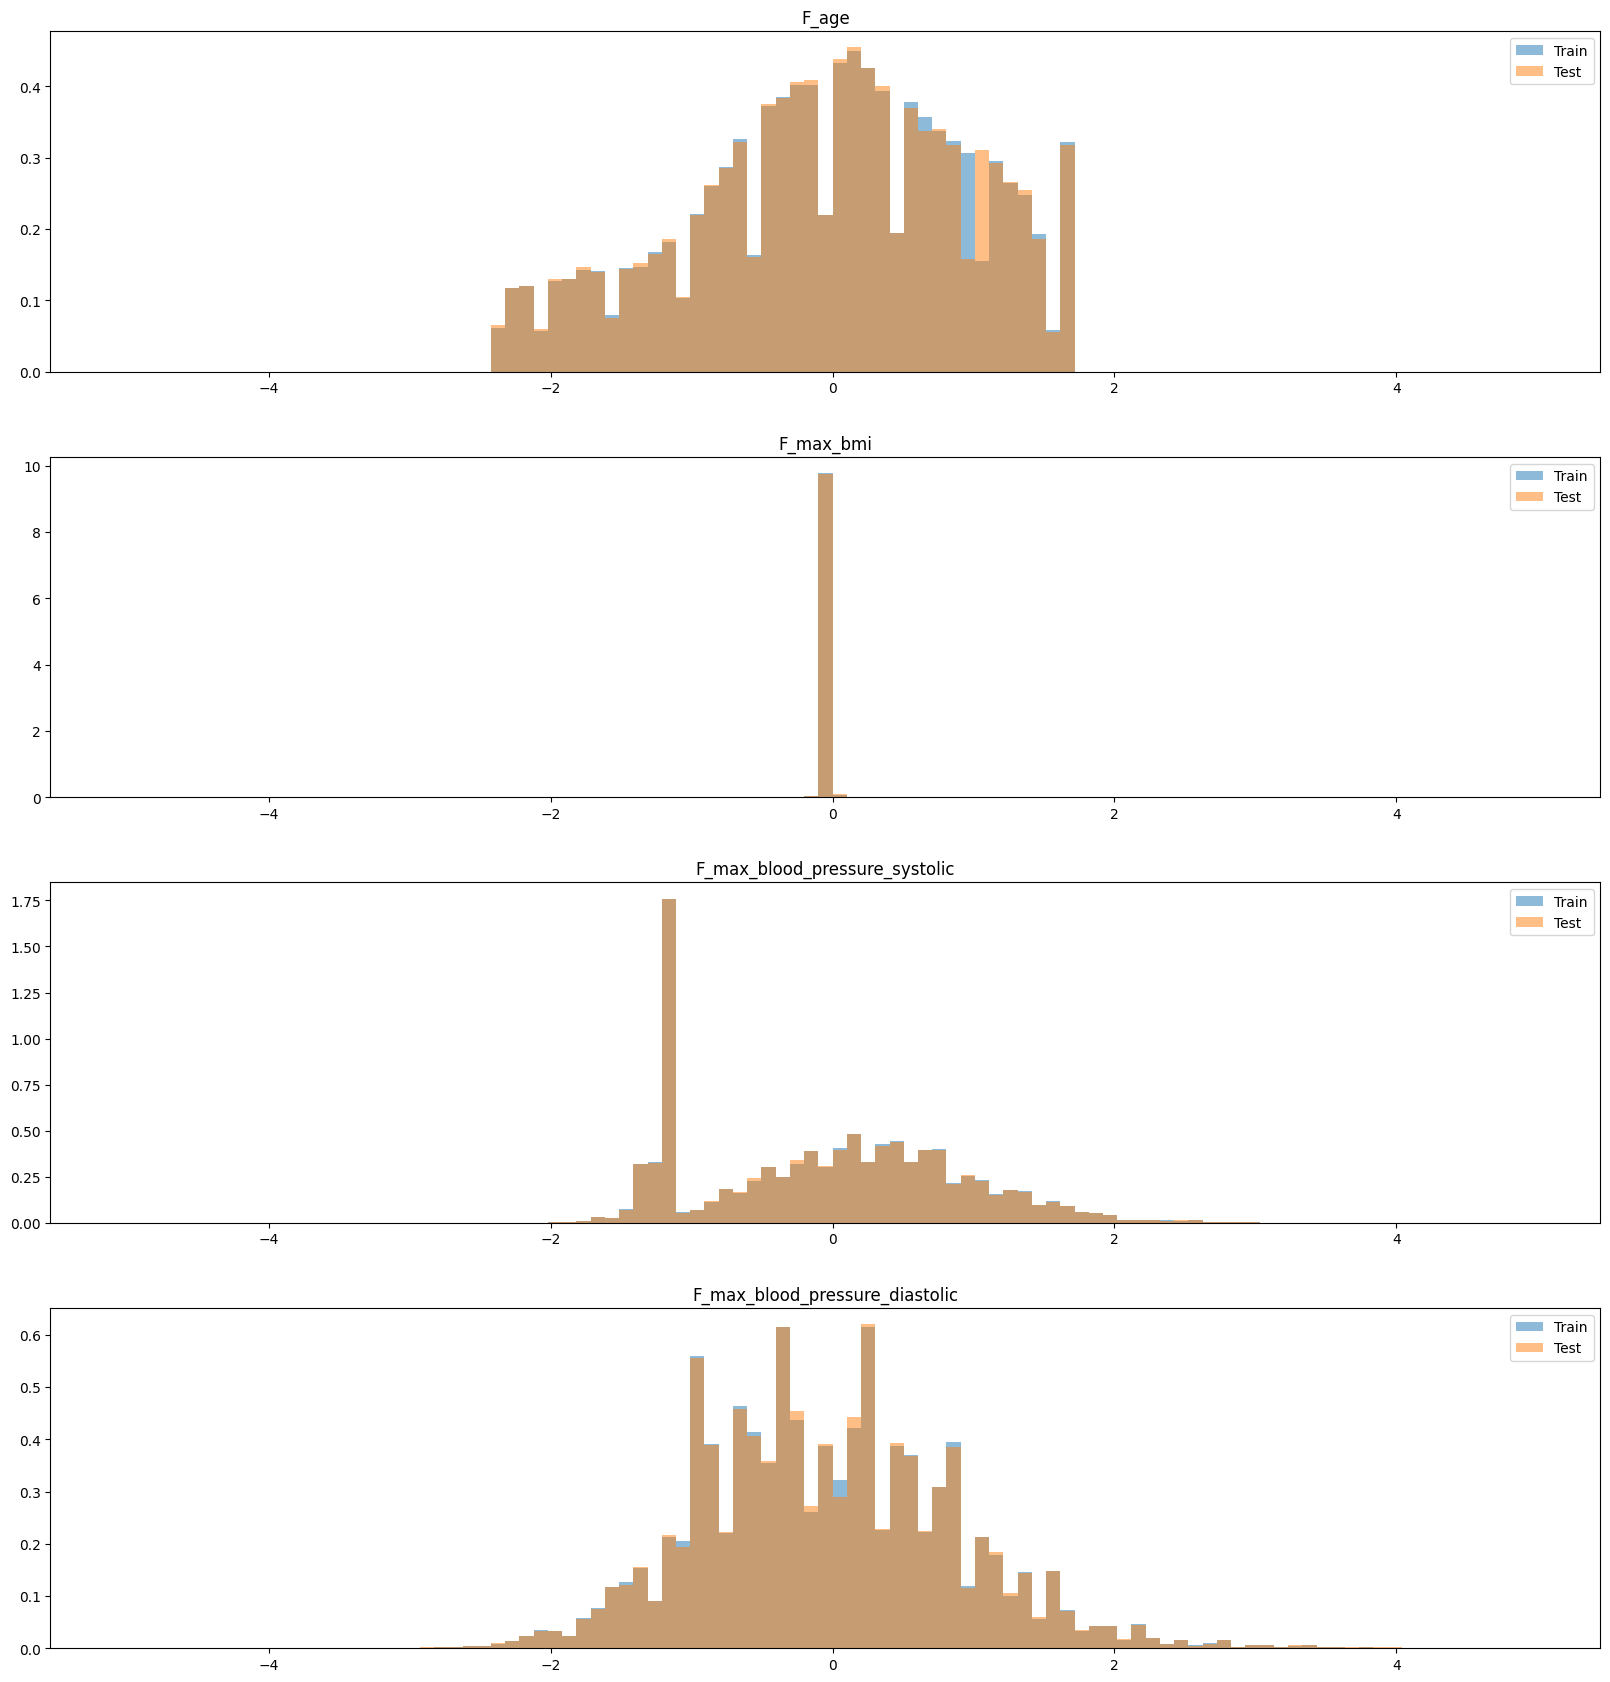

In [18]:
## Quilt rows and columns ##
nCols=1
nRows=len(continuous_features)
## Spacers ##
wspace= 0.
hspace= 0.25
## Quilt width and height ##
figsize_x = 20+(wspace*nCols)
figsize_y = 5*(nRows/nCols)+(hspace*nRows)

## Plot Tiles ##
fig, ax = plt.subplots(nrows=nRows, ncols=nCols, figsize=(figsize_x, figsize_y), 
                       gridspec_kw = {'wspace':wspace, 'hspace':hspace}) 

bins_normalized = np.linspace(-5,5,100)
for row, c_feature in enumerate(continuous_features):
    ax[row].hist(train_imputated_df[c_feature], bins=bins_normalized, density=True, align='left', alpha=0.5, label='Train');
    ax[row].hist(test_imputated_df[c_feature], bins=bins_normalized, density=True, align='left', alpha=0.5, label='Test');
    ax[row].legend();
    ax[row].set_title(c_feature);
plt.show();

### Plot: Compare Discrete Distributions

In [19]:
## Quilt rows and columns ##
nCols=1
nRows=len(discrete_features)
## Spacers ##
wspace= 0.
hspace= 0.25
## Quilt width and height ##
figsize_x = 100 # 20+(wspace*nCols)
figsize_y = 100 # 5*(nRows/nCols)+(hspace*nRows)

## Plot Tiles ##
fig, ax = plt.subplots(nrows=nRows, ncols=nCols, figsize=(figsize_x, figsize_y), 
                       gridspec_kw = {'wspace':wspace, 'hspace':hspace}) 

for row, c_feature in enumerate(discrete_features):
    bins_normalized = np.linspace(0, int(train_imputated_df[c_feature].max())+1, int(train_imputated_df[c_feature].max()+2))
    ax[row].hist(train_imputated_df[c_feature], bins=bins_normalized, log=True, density=True, align='left', alpha=0.5, label='Train');
    ax[row].hist(test_imputated_df[c_feature], bins=bins_normalized, log=True, density=True, align='left', alpha=0.5, label='Test');
    ax[row].legend();
    ax[row].set_title(c_feature);
plt.show();

### Plot: Compare Outcome Distribution 

/Users/lhuang21/Library/Python/3.9/lib/python/site-packages/matplotlib/axes/_axes.py:6859: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


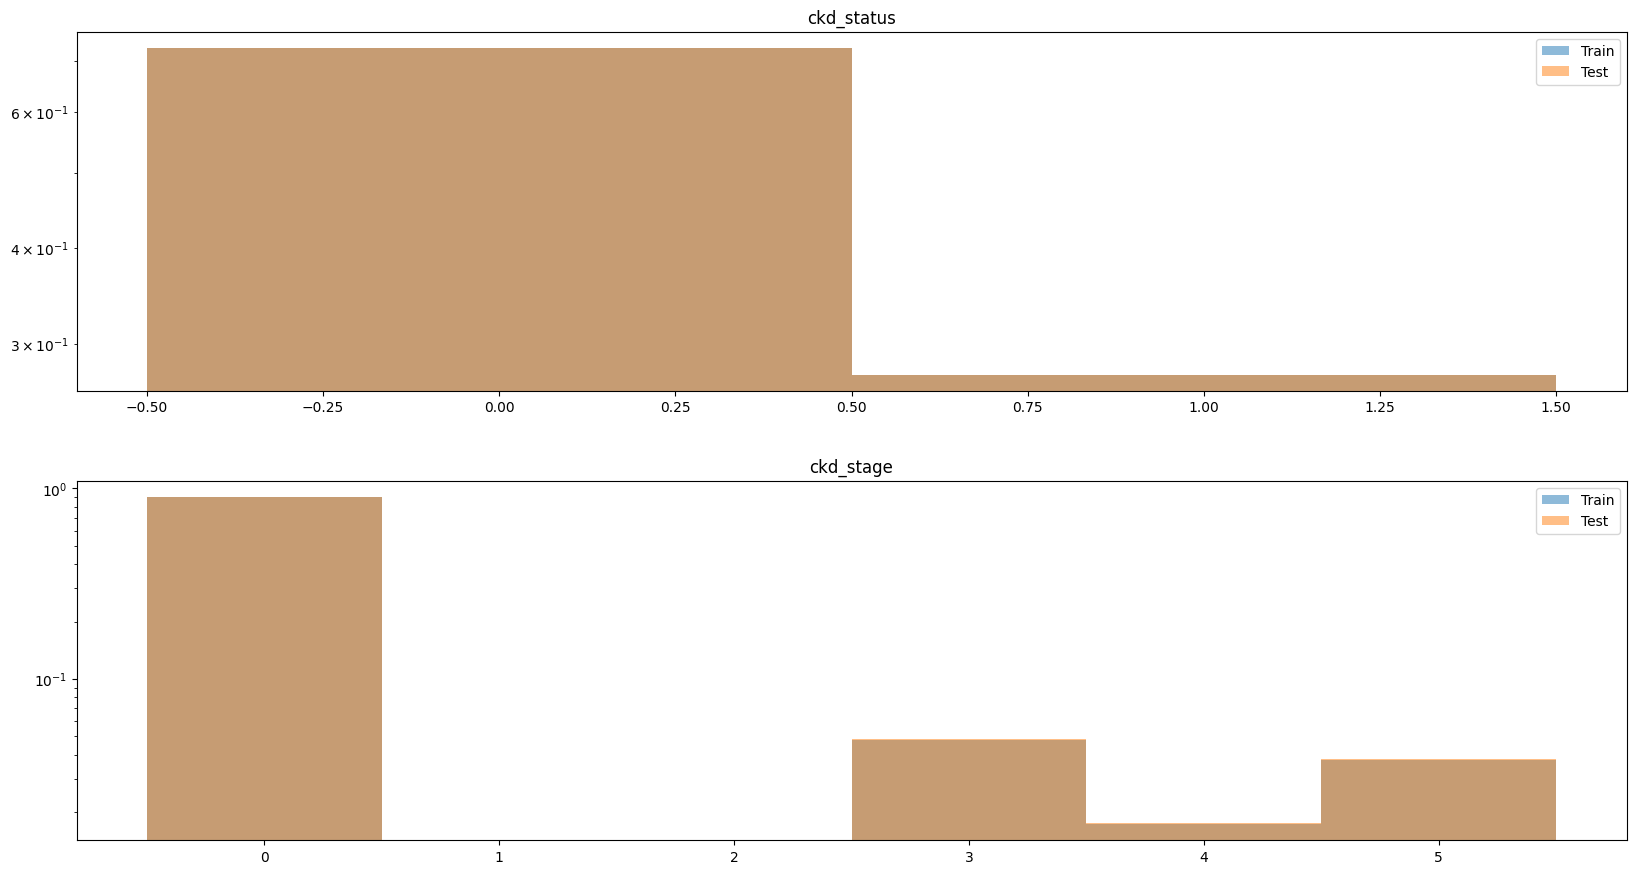

In [20]:
## Quilt rows and columns ##
nCols=1
nRows=len(outcome_cols)
## Spacers ##
wspace= 0.
hspace= 0.25
## Quilt width and height ##
figsize_x = 20+(wspace*nCols)
figsize_y = 5*(nRows/nCols)+(hspace*nRows)

## Plot Tiles ##
fig, ax = plt.subplots(nrows=nRows, ncols=nCols, figsize=(figsize_x, figsize_y), 
                       gridspec_kw = {'wspace':wspace, 'hspace':hspace}) 

for row, c_feature in enumerate(outcome_cols):
    bins_normalized = np.linspace(0, int(train_imputated_df[c_feature].max())+1, int(train_imputated_df[c_feature].max()+2))
    ax[row].hist(train_imputated_df[c_feature], bins=bins_normalized, log=True, density=True, align='left', alpha=0.5, label='Train');
    ax[row].hist(test_imputated_df[c_feature], bins=bins_normalized, log=True, density=True, align='left', alpha=0.5, label='Test');
    ax[row].legend();
    ax[row].set_title(c_feature);
plt.show();

### Plot: Fraction of Patients with Feature Value vs Features

/var/folders/65/qxp2fcwj00bff0rdg3hmhyx80000gn/T/ipykernel_57166/2516037226.py:2: DtypeWarning: Columns (30,41,42,68,69,70,71,85,89,105,106,107,125,126,127) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv(ORIGINAL_DATA_PATH, index_col=0)
/Users/lhuang21/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


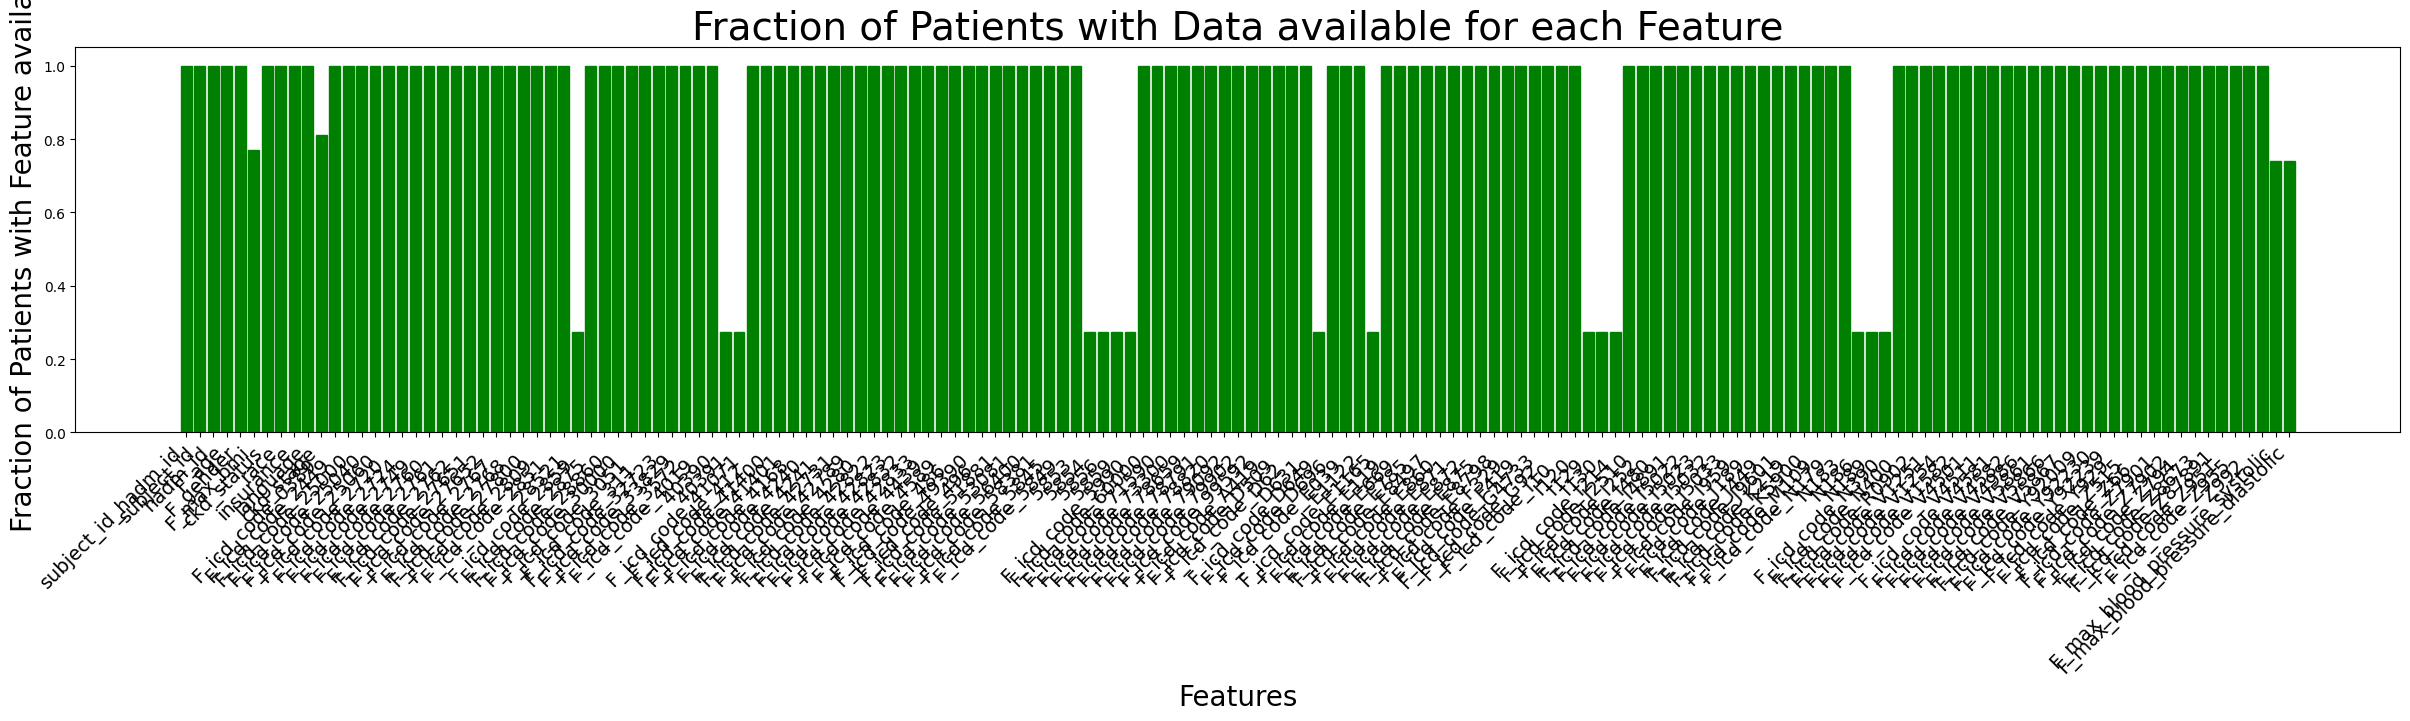

In [21]:
## Read Data from CSV ##
df_original = pd.read_csv(ORIGINAL_DATA_PATH, index_col=0)
original_features=df_original.columns

plt.figure(figsize=(30,5))
barlist = plt.bar(original_features, np.sum(~df_original[original_features].isnull()) / len(df_original[original_features]) )

## Color bars representing removed features ##
for i in range(len(barlist)):
    ## Red: Feature with too many missing values
    if 'F_'+original_features[i] in too_much_missing_data_cols:
        barlist[i].set_color('r')
    ## Yellow: Discrete features with very low incidence
    elif 'F_'+original_features[i] in one_hot_outlier_cols:
        barlist[i].set_color('y')
    ## Green: Not removed
    else:
        barlist[i].set_color('g')

plt.title('Fraction of Patients with Data available for each Feature', fontsize=28); 
plt.ylabel('Fraction of Patients with Feature available', fontsize=20); plt.xlabel('Features', fontsize=20);
plt.xticks(ha='right', rotation=45, fontsize=14);
plt.show();